## Prep

#### Import modules

In [1]:
from ChromoGen import Conformations
from ChromoGen.data_utils import HiCDataset
from ChromoGen.model.Diffuser.training_utils import ConfigDataset
import torch
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.style.use('../support/plot_style.txt')

2024-11-26 16:38:29.967637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The following is taken from [here](https://github.com/BogdanBintu/ChromatinImaging/blob/master/CommonTools/PostAnalysisTools.py), except translated to Python 3. See `../Figure_4/domain_boundary_support/README.md` for more information.

In [4]:
import sys
sys.path.insert(0,'../Figure_4/domain_boundary_support/')
from PostAnalysisTools import StandardBoundaryAnalysis

#### Settings

In [22]:
#### 
# Filepaths

# Pre-existing data
cgen_coord_dir = '../../downloaded_data/conformations/ChromoGen/specific_regions/GM12878/'

mcool_fp = '../../outside_data/hic/GM12878_hg19.mcool'

formatted_dipc_fp = '../../downloaded_data/conformations/DipC/processed_data.h5'

# Where to place data created by this script
temp_data_dir = './temp_data/'
pdf_dir = './pdfs/'

####
# Analysis

# Regions to analyze
chroms_genomic_indices = {
    '21':[28_500_000]
}

# Resolution of the data (in bp)
resolution = 20_000
num_bins = 64

# Guidance parameters used during generation to consider
guidance_params = [
    (1.,0.), # (cond_scale, rescaled_phi)
    (5.,8.)
]

# Single (False) or double (True) precision?
high_precision = True

# Whether to recompute & overwrite the results file, even if analysis was already performed
force_computation = False 

####
# Plot settings

# Colors to use in bottom part of 4b
colors = ['red','lightblue']

# Upper triangle of Fig 4a-type plots. 
# Also left in top of Fig 4b, colors[0] in bottom of Fig 4b
upper_triangle_cell_type = 'ChromoGen' 

#### Verify settings, initialize some objects

In [23]:
hic_dataset = HiCDataset(mcool_fp)

cgen_coord_dir = Path(cgen_coord_dir)

config_ds = ConfigDataset(
    formatted_dipc_fp,
    segment_length=num_bins,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=list(chroms_genomic_indices),
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=None,
    mean_sq_dist_fp=None,
)

temp_data_dir = Path(temp_data_dir)
pdf_dir = Path(pdf_dir)

temp_data_dir.mkdir(exist_ok=True,parents=True)
pdf_dir.mkdir(exist_ok=True,parents=True)

## Analyze

#### Load all conformations. Represent coordinates as NumPy ndarrays for compatibility with Bintu's analysis code. 

In [15]:
coord_dict_np = {'ChromoGen':{}, 'Dip-C':{}}
for chrom, start_indices in chroms_genomic_indices.items():

    for start_indices in start_indices:
        si = start_indices // 1000
        coords = []
        for cs,rp in guidance_params:
            fn = f'chrom_{chrom}/start_idx_{si}_cond_scale_{cs}_rescaled_phi_{rp}.pt'
            
            # drop_invalid_conformations drops any conformations with NaN values inside. 
            # For the region analyzed in the paper, this removed 0 and 3 conformations in 
            # IMR-90 and GM12878, respectively. 
            coords.append(Conformations(cgen_coord_dir/fn,drop_invalid_conformations=True))

        # Combine coordinates generated with all guidance settings
        coords = coords[0].cat(coords[1:])

        # Load the Dip-C coordinates
        dipc_coords = Conformations(config_ds.fetch_specific_coords(chrom,start_indices)[-1])
        
        # Coordinates instance -> torch.Tensor via `.values`
        # Saved precision (usually float32) -> desired precision via `.double()`/`.float()`
        # torch.Tensor -> numpy.ndarray via `.numpy()`
        # reduced units -> nm via `* 100`
        key = f'{chrom}_{si}'
        if high_precision:
            coord_dict_np['ChromoGen'][key] = coords.values.double().numpy() * 100
            coord_dict_np['Dip-C'][key] = dipc_coords.values.double().numpy() * 100
        else:
            coord_dict_np['ChromoGen'][key] = coords.values.float().numpy() * 100
            coord_dict_np['Dip-C'][key] = dipc_coords.values.float().numpy() * 100


Compute domain boundary statistics

In [16]:
pbar = tqdm(initial=0, total=len(coord_dict_np))
boundary_data = {}

for cell_type in coord_dict_np:
    ct = cell_type
    
    pbar.set_description(f'Now processing/loading {ct}')
        
    boundary_file = str(temp_data_dir / f'{ct}.pkl')

    dict1 = coord_dict_np[ct]
    boundary_data[ct] = StandardBoundaryAnalysis(
        tags = list(dict1),            # Keys in dict to analyze (i.e., all of them)
        dic_zxys = dict1,              # Conformations for each region related to this particular cell type
        boundary_file=boundary_file,   # Save file
        overwrite = force_computation, # Whether to force the calculation even if previously performed
        ####
        # Various computation parameter selections here. 
        # We just used the default values (reflected here).
        gb=1,
        valley=1,
        su=10,
        sl=6,
        coverage_th=0.5,
        bad_hybe_cov_th=0.5,
        ####
        cols=[[[0,0,0],[0.5,0.5,0.5]]]*len(dict1), # Color values. Unused since plt_val==False, 
                                                   # but necessary due to how StandardBoundaryAnalysis() was written
        plt_val=False                         # Don't plot the results 
    )
    
    pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

Number of chromosomes: 19996
Number of chromosomes: 73


## Plot

#### Functions

NOTE: Some of this was adapted from some of Bintu's code in `./domain_boundary_support/PostAnalysisTools.py`, but modified to maintain consistency with the other figures in our own manuscript. 

In [24]:
def label_ul_triangles(
    ax,
    upper_label,
    lower_label,
    buffer_frac=0.005,
    color='black',
    foreground='white',
    linewidth=1,
    fontsize='small'
):

    # Decide where to anchor the text
    minn,maxx = ax.get_xlim()
    buffer = (maxx-minn) * buffer_frac
    high = maxx - buffer
    low = minn + buffer
    
    # Label the upper triangle
    ax.text(high,low,upper_label,horizontalalignment='right',verticalalignment='top',
            color=color,path_effects=[pe.withStroke(linewidth=linewidth, foreground=foreground)],
            fontsize=fontsize)
    
    # Label the lower triangle
    ax.text(low,high,lower_label,horizontalalignment='left',verticalalignment='baseline',
            color=color,path_effects=[pe.withStroke(linewidth=linewidth, foreground=foreground)],
            fontsize=fontsize)

def padded_lims(vals,pad_frac=0.05):
    lims = [np.min(vals),np.max(vals)]
    pad = (lims[1]-lims[0]) * pad_frac
    return [lims[0]-pad,lims[1]+pad]
                
def make_plot(
    region,
    boundary_data=boundary_data,
    tag1=upper_triangle_cell_type,
    distmaps1=(0,1), # Index of individual conformations to plot among tag1 data
    distmaps2=(0,1), # Index of individual conformations to plot among tag2 data
    hic_datasets={key:hic_dataset for key in coord_dict_np},
    coord_dict=coord_dict_np,
    dist_vmax=1500,
    legend_text_size='small',
    colors = colors,
    figsize=None,
    balance_hic = True,
    interp_hic_nans = True,
    cbar_orientation='horizontal',
    layout='constrained'
):

    ######################
    # Preparation 
    
    # Get tag2 (lower triangle in part a/right maps in top of part b/blue in bottom of part b)
    tags = list(boundary_data)
    tag2 = tags[1] if tags[0] == tag1 else tags[0]

    ###
    # Select the relevant data from each dictionary/load where necessary

    # Coordinates
    coords1 = Conformations(coord_dict[tag1][region])
    coords2 = Conformations(coord_dict[tag2][region])

    # Boundary data computed with Bintu code
    #data1 = boundary_data[tag1][region]
    #data2 = boundary_data[tag2][region]

    # Need some info about the region to load the Hi-C data
    chrom, start_idx = region.split('_')
    start_idx = int(start_idx) * 1_000
    stop_idx = start_idx + coords1.num_beads * resolution

    # Hi-C maps
    hic_map1 = hic_datasets[tag1].fetch(chrom, start_idx, stop_idx, balance=balance_hic, interp_nans = interp_hic_nans)
    hic_map2 = hic_datasets[tag2].fetch(chrom, start_idx, stop_idx, balance=balance_hic, interp_nans = interp_hic_nans)

    ######################
    # Plot

    ####
    # Initialize the figure
    figsize = (6.69291*.4,6.69291*.5) if figsize is None else figsize
    fig,axes = plt.subplots(nrows=2,ncols=2,figsize=figsize,layout=layout)
    fig1, axes1 = plt.subplots(nrows=2,ncols=2,figsize=figsize,layout=layout)
     
    # Hold all cbars to return in here
    cbars = []

    ########
    # Part a plots
    
    ####
    # Experimental Hi-C
    ax = axes[0][0]
    *_,cbar = hic_map1.plot_with(hic_map2,fig=fig,ax=ax,cbar_orientation=cbar_orientation)
    label_ul_triangles(ax, tag1, tag2)
    cbar.set_label("Interaction frequency")
    cbars.append(cbar)
    cbar.set_ticks([1.e-02,1.e+00])
    cbar.ax.minorticks_off()
    
    ####
    # Median distance maps
    ax = axes[0][1]

    d1 = coords1.distances.median
    d2 = coords2.distances.median
    n = d1.num_beads
    i,j = torch.triu_indices(n,n,1)
    vmin = min(d1.values[0,i,j].min(),d2.values[0,i,j].min())
    vmax = max(d1.values[0,i,j].max(),d2.values[0,i,j].max())
    _,_,_,cbar=d1.plot_with(d2,fig=fig,ax=ax,cbar_orientation='horizontal',vmin=vmin)
    label_ul_triangles(ax,tag1,tag2)
    cbar.set_label("Distance (nm)")
    vmax = vmax//100 * 100
    vmin1 = vmin//100 * 100
    while vmin1 < vmin:
        vmin1+=50
    vmax = int(vmax)
    vmin1 = int(vmin1)
    cbar.set_ticks([vmin1,vmax],labels=['$\\mathdefault{'+f'{vmin1}'+'}$','$\\mathdefault{'+f'{vmax}'+'}$'])
    ax.set_ylabel('')
    cbars.append(cbar)

    ########
    # Part b plots

    ####
    # Single-conformation distance maps 

    for i,(tag, coords, distmap_indices) in enumerate(
        [
            (tag1, coords1, distmaps1),
            (tag2, coords2, distmaps2)
        ]
    ):

        for j, d_idx in enumerate(distmap_indices):
            ax = axes1[j][i]
            *_, cbar = coords[d_idx].distances.plot(fig=fig1,ax=ax,vmax=dist_vmax)
            ax.set_xlabel('')
            if i > 0:
                ax.set_ylabel('')
            else:
                cbar.remove()
        
    

    ####
    # Boundary probabilities & strengths (adapted from Bintu's code)

    dic = boundary_data
    prob_x_extremes = [np.inf,-np.inf]
    prob_y_extremes = [np.inf,-np.inf]
    hist_y_max = 0
    for i,tag in enumerate([tag1,tag2]):

        # Fetch the relevant data for this specific set of conformations
        xs,means,rs,col = dic[tag][region]['xs'],dic[tag][region]['means'],dic[tag][region]['rs'],dic[tag][region]['col']
        color = colors[i]
    
        # Probabilities plot
        ax = axes[-1][1]
        ax.plot(xs,means,'.-',color=color,label=tag,alpha=.5)
        prob_x_extremes[0] = min(prob_x_extremes[0],np.min(xs))
        prob_x_extremes[1] = max(prob_x_extremes[1],np.max(xs))
        prob_y_extremes[0] = min(prob_y_extremes[0],np.min(means))
        prob_y_extremes[1] = max(prob_y_extremes[1],np.max(means))
    
        # Histogram
        ax = axes[-1][0]
        vals,borders,_ =ax.hist(rs,bins=np.linspace(0.5,4,20),color=color,edgecolor='none',label=tag,alpha=.5,
                               density=True)
        hist_y_max = max(hist_y_max,np.max(vals))

    ########
    # Labels, etc., for the last two axes

    ####
    # Probabilities plot
    ax = axes[-1][1]

    # Place ticks, labels on right
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    # Axis labels
    ax.set_xlabel('Segment index')
    ax.set_ylabel('Probability')

    # Axis limits
    ax.set_xlim(padded_lims(prob_x_extremes,.05)) # ymax=1.15*extreme in the other region
    ax.set_ylim(padded_lims([prob_y_extremes[0],prob_y_extremes[1]*1.35],.05))

    # Legend
    ax.legend(framealpha=0,fontsize=legend_text_size,loc='upper left')
    ax.set_yticks([0.,.1,.2])

    ####
    # Histogram
    ax = axes[-1][0]
    vls = np.linspace(0,hist_y_max,5)
    ax.set_yticks([0,1,2],labels=['$\\mathdefault{0}$','$\\mathdefault{1}$','$\\mathdefault{2}$'])
    ax.set_xlabel('Boundary strength')
    ax.set_xlim([0,4])
    ax.set_ylabel('Probability Density')
    ax.legend(framealpha=0,fontsize=legend_text_size)

    #### 
    # Additional formatting
    
    # Force plots to be square
    for ax in [axes[-1][0],axes[-1][1]]:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))

    suptitle = (
        f"Chromosome {str(chrom).replace('chr','')}: "
        f"{round(start_idx/1e6,2)}-{round(stop_idx/1e6,2)} Mb"
    )
    fig.suptitle(suptitle)

    return fig, axes, fig1, axes1

    

#### Plot and save

Unfortunately, I accidentally overwrote the original files here, so I can't show the _exact_ conformations used in the manuscript. However, some comparable conformations were generated on the second attempt. 

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 47 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'G', 'I', 'M', 'P', 'S', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'seven', 'space', 't', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 37, 38, 39, 42, 44, 48, 51, 54, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 1894]
INFO:fontT

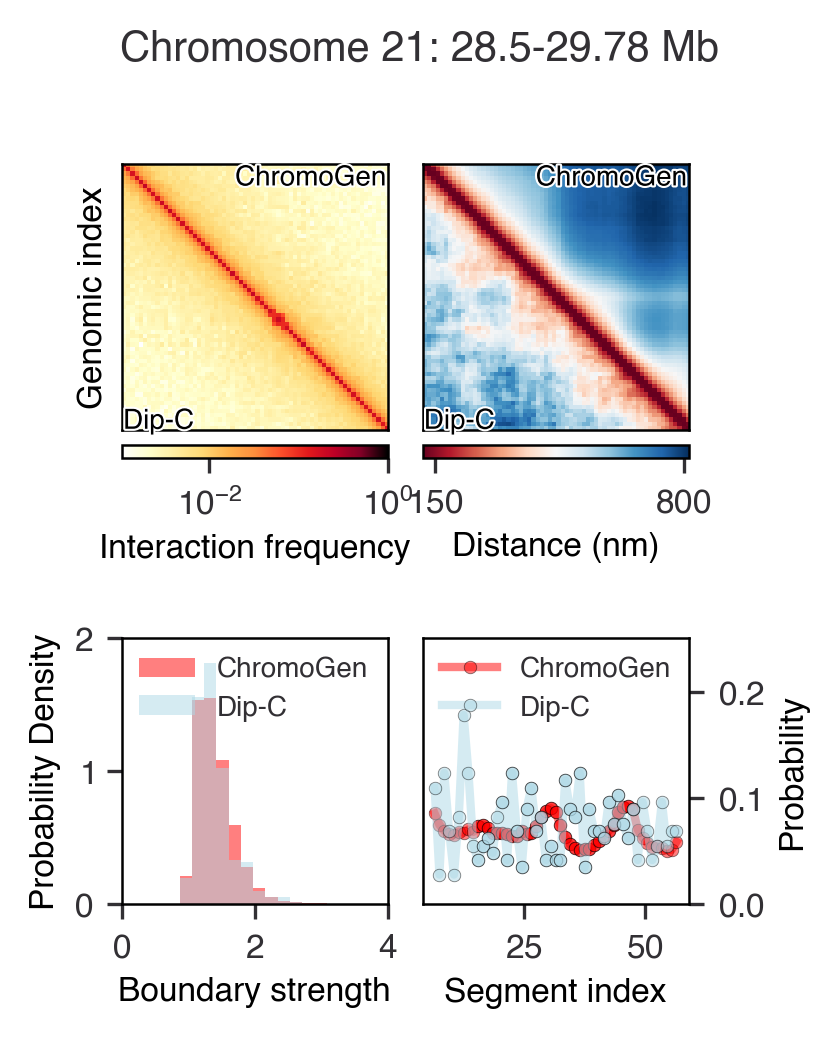

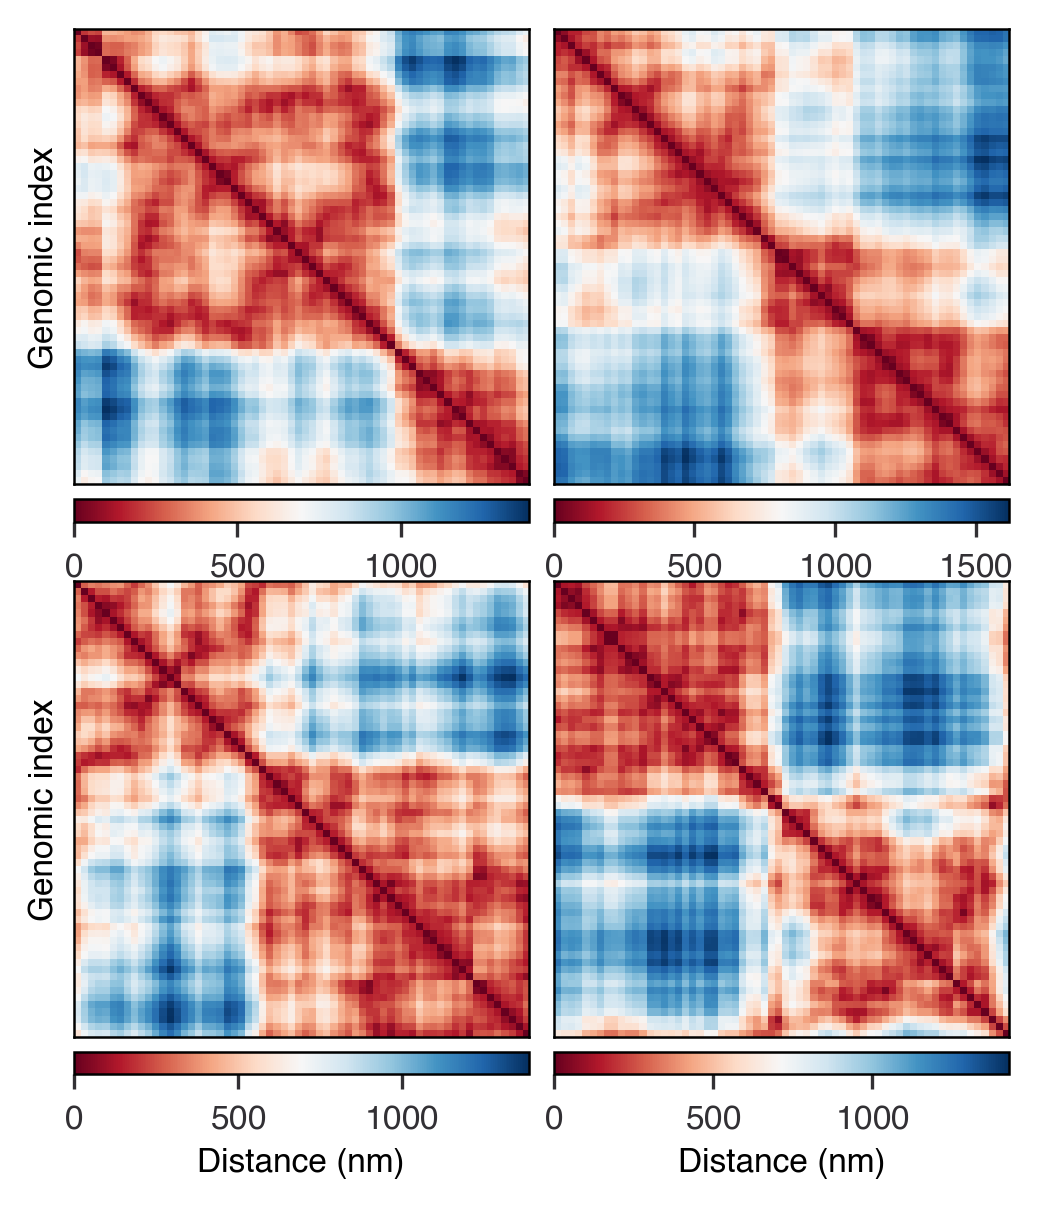

In [27]:
for chrom,start_indices in chroms_genomic_indices.items():
    for si in start_indices:
        region = f'{chrom}_{si//1000}'

        dipc_coords = Conformations(coord_dict_np['Dip-C'][region])
        
        fig,axes,fig1,axes1 = make_plot(
            region,
            distmaps1=(0,1),
            distmaps2=(0,1)
        )
        fig.savefig( pdf_dir / f'stats_{region}.pdf', transparent=True)
        plt.close(fig1)

        ####
        # Distances
        fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(6.69291*.5,6.69291*.55),layout='constrained')
        for k, idx in enumerate([38,41,42,68]):
            ii = k%2
            jj = k//2
            ax = axes[ii][jj]
            
            *_,cbar = dipc_coords[idx].distances.plot(fig=fig, ax=ax,cbar_orientation = 'horizontal')

            if ii == 0:
                cbar.set_label('')
            else:
                cbar.set_label('Distance (nm)')
            if jj == 1:
                ax.set_ylabel('')
        fig.savefig(pdf_dir / f'distmaps_{region}.pdf')

Figures were moved around in Adobe Illustrator. 